# HW 5. RHRNet for Audio Denoising. 

В домашней работе вы познакомитесь с задачей разделения шума и речи в одноканальном аудиосигнале.

 Работать будем с датасетами **TIMIT**: это датасет чистой речи, люди с разными диалектами американского английского читают предложения. Вторым датасетом будет датасет шумов **DEMAND**.

 Моделью денойзинга будет **[RHRNet](https://arxiv.org/ftp/arxiv/papers/1904/1904.07294.pdf)**. Общая архитектура модели напоминает **U-net**, где каждый блок представляет собой двунаправленную реккурентную сеть. Модель работает с маленькими участками аудиофайла длиной $1024$, что при частоте дискретизации $16$ kHz соответствует $16$ ms.

**Наш план**:

- Научиться работать с аудиоданными: добавлять шум к аудио с разными уровнями **SNR**
- Создать датасеты для обучения и тестирования. 
- Реализовать модель
- Реализоввать инфраструктурные функции для обучения модели
- Обучить модель
- Посмотреть результаты

Импорт необходимых библиотек :)

In [ ]:
import numpy as np
import itertools
import torch
import librosa
import math

from glob import glob
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torch.nn import functional as F
from IPython import display as ipd
from torch.utils.data import DataLoader, Dataset

# 9.1 Посмотреть на данные (2 балла)

## Примеры DEMAND

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

In [ ]:
data_root = '/content/gdrive/MyDrive/DEMAND' # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
demand_paths = [data_root + '/' + x for x in list(os.walk(data_root))[0][2]] # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯ paths to audios

In [ ]:
idxs = [0, 88, 191]

Для работы с аудио будем использовать библиотеку **librosa**. 

Так как мы все тут *эксперты* по звуку, то сразу же посмотрим спектральные характеристики представленных шумов. 

In [ ]:
audios = []
for idx in idxs:
    x, sr = librosa.load(demand_paths[idx], sr=16000)
    print(sr)
    audios.append(x)

16000
16000
16000


Воспользуйтесь функцией **librosa.dispalay.waveplot**, чтобы отрисовать амплитуды аудиозаписей на участке, соответствующем одной секунде.

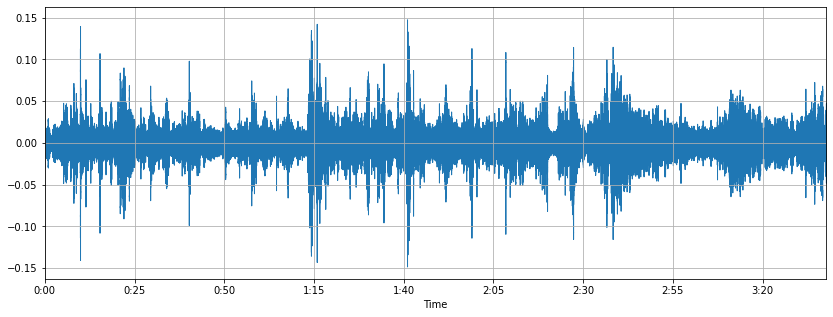

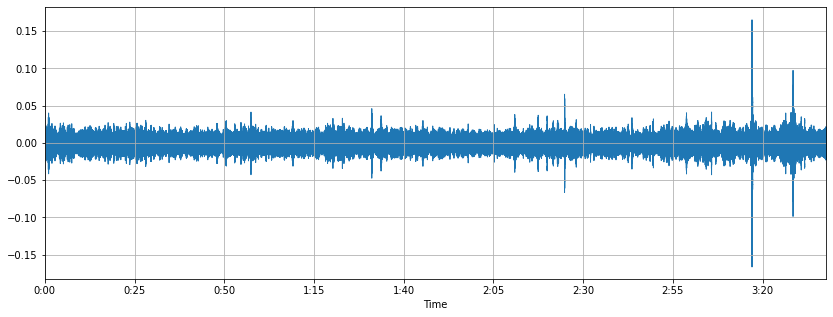

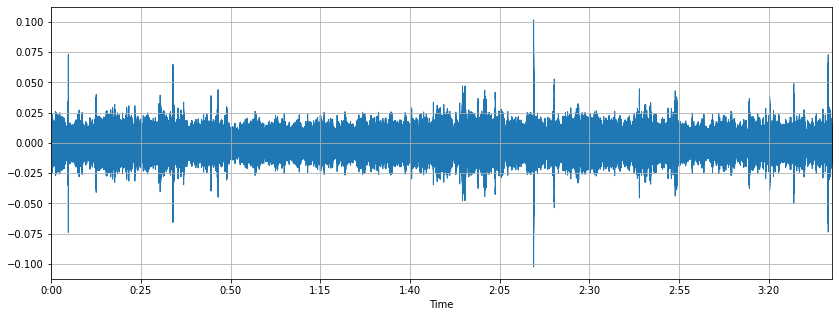

In [ ]:
import librosa.display
for x in audios:
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
    plt.grid()
    plt.show()

Воспользуйтесь функциями librosa.stft, librosa.amplitude_to_db, librosa.display.specshow, чтобы получить и отрисовать спектрограммы выбранных аудиозаписей.

Дополнительно, ознакомьтесь с **STFT**(short-term-fourier-transform).

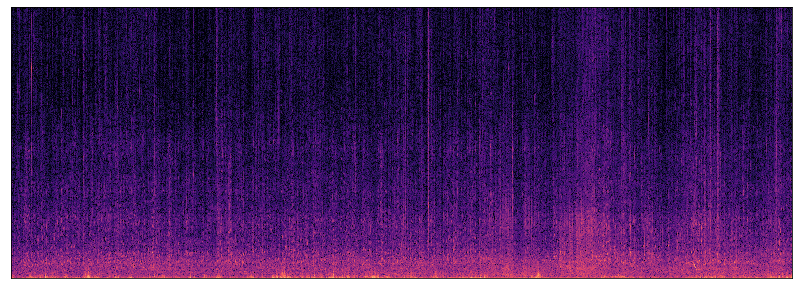

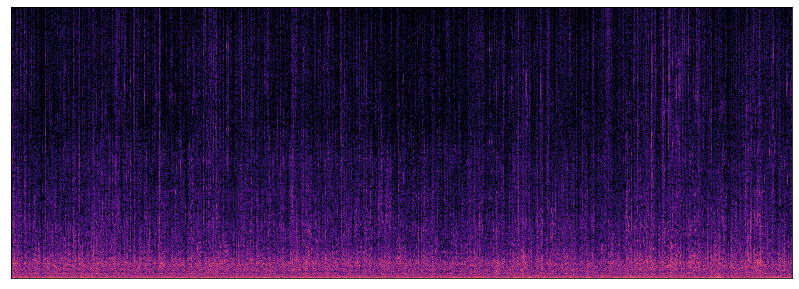

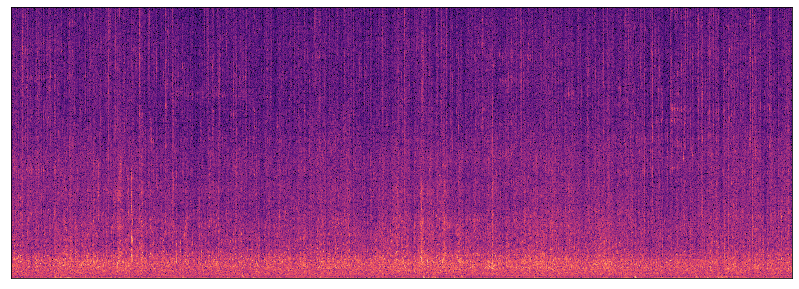

In [ ]:
for x in audios:
    plt.figure(figsize=(14, 5))
    spgr = librosa.stft(x)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(spgr)))# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
    plt.grid()
    plt.show()

## Примеры TIMIT

Теперь посмотрим на образцы речи, которые мы будем использовать в качестве элалонной чистой речи.

In [ ]:
data_root = '/content/gdrive/MyDrive' # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
timit_train_paths = glob(f"{data_root}/TIMIT/TRAIN/*/*/*.WAV")
timit_test_paths = glob(f"{data_root}/TIMIT/TEST/*/*/*.WAV")

In [ ]:
idxs = [0, 88, 191]

In [ ]:
audios = []
for idx in idxs:
    x, sr = librosa.load(timit_test_paths[idx], sr=16000 )
    print(sr)
    audios.append(x)

16000
16000
16000


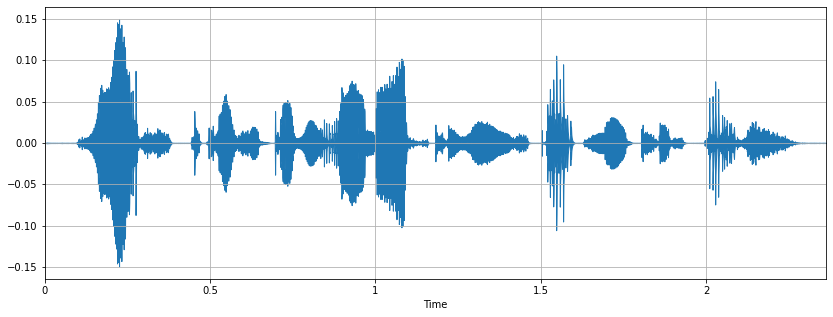

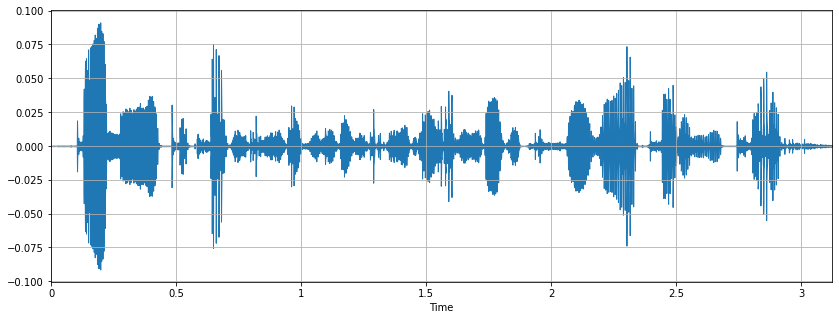

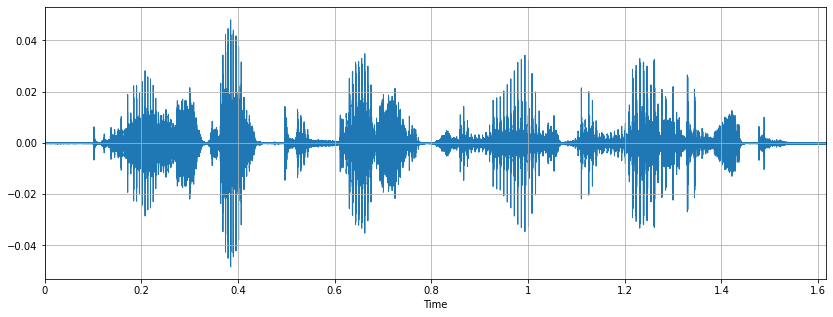

In [ ]:
import librosa.display
for x in audios:
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x) # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
    plt.grid()
    plt.show()

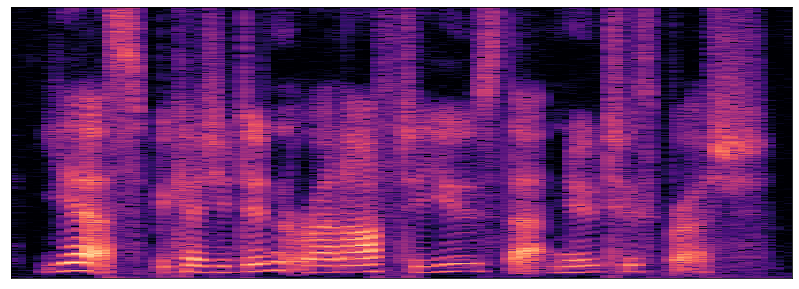

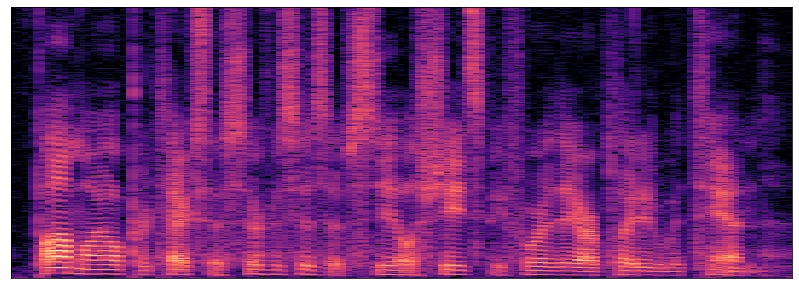

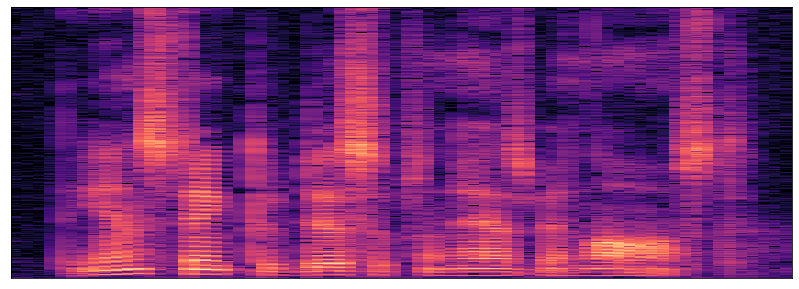

In [ ]:
for x in audios:
    plt.figure(figsize=(14, 5))
    spgr = librosa.stft(x)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(spgr))) # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
    plt.grid()
    plt.show()

## Слияние шума и речи (2 балла)

Нам необходимо слить аудиозаписи и шумы с заданным **[SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)**.

In [ ]:
def add_noise(clean, noise, snr):
    #####################################
    # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
    #####################################
    rms_noise = (noise ** 2).mean()
    rms_clean = (clean ** 2).mean()
    snr = 10 ** (snr / 10)
    coef = np.sqrt(rms_clean / snr) / np.sqrt(rms_noise)
    return coef * noise + clean

In [ ]:
noise, sr = librosa.load(demand_paths[0], sr=16000 )
clean, sr = librosa.load(timit_test_paths[0], sr=16000 )
noise = noise[:len(clean)]
noisy_high = add_noise(clean, noise, 15)
noisy_low = add_noise(clean, noise, -5)

Отрисуйте спектрограммы **clean, noisy_high, noisy_low.**

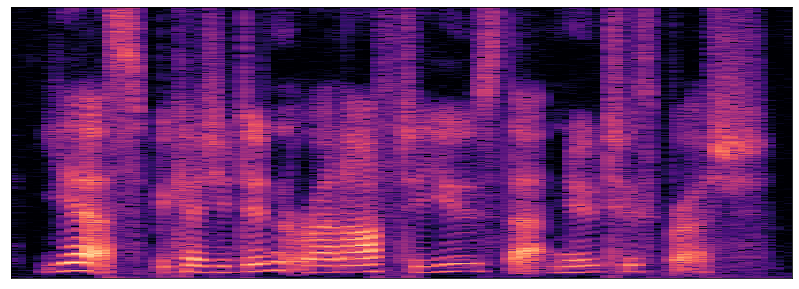

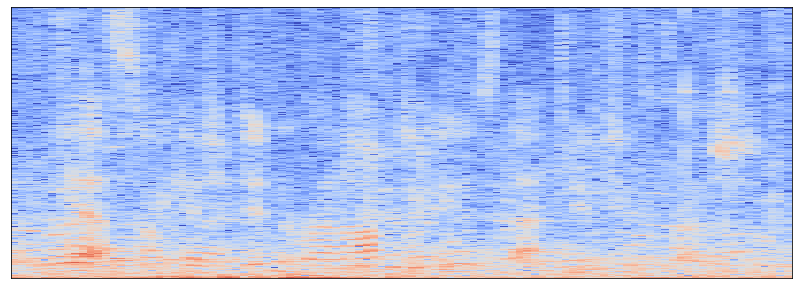

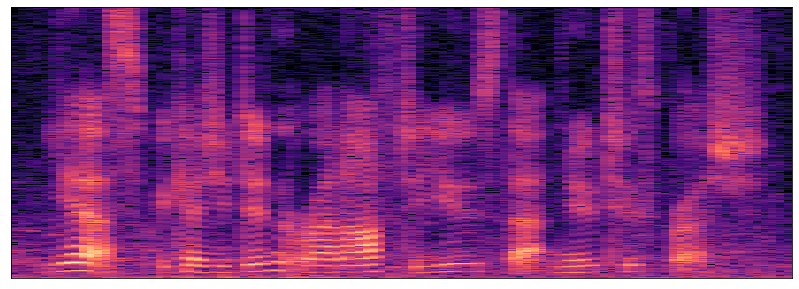

In [ ]:
for x in [clean, noisy_low, noisy_high]:
    plt.figure(figsize=(14, 5))
    spgr = librosa.stft(x)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(spgr)))
    plt.grid()
    plt.show()

Убедитесь, что низким значениям SNR соотыктстуют спектрограммы, похожие на шум, в то время как для значений в диапазоне 15-20, изменения выглядят не так существенно. 

## 9.2 Pytorch Datasets (2 балла)
### Train Dataset
Будем генерировать датасеты на лету, при этом тут есть подводный камень. Так как сегменты очень маленькие, то считывать файл с шумом и речью для каждого такого сегмента бессмысленно, поэтому будем считывать по целой аудиозаписи и на каждой итерации генерировать несколько сегментов для обучения.

Но в такой ситуации, чтобы случайно не переполнить память, ограничим количество сегментов в одной аудиозаписи.

In [ ]:
def collate_segments(inputs):
    """
    Performs batch creation from list of source signals.

    Parameters
    ----------
    inputs : tuple of list of tensors
        Input 1d arrays.

    Returns
    -------
    Tuple with clear and noised audios.

    """

    output = list(zip(*inputs))
    noisy = output[0]
    clear = output[1]

    noisy = torch.cat(noisy)
    clear = torch.cat(clear)

    return noisy, clear


class FastSegmentDataset(Dataset):
    def __init__(self, clean_paths, noise_paths, segment_length=1024, 
                 max_num_segments=80, snr_range=(0, 10)):

        self.max_num_segments = max_num_segments
        self.segment_length = segment_length
        self.noise_paths = noise_paths
        self.clean_paths = clean_paths
        self.snr_start = snr_range[0]
        self.snr_length = snr_range[1] - snr_range[0]

    def __len__(self):
        return len(self.clean_paths)

    def __getitem__(self, item):
        #####################################
        # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
        #####################################
        noise_item = np.random.randint(len(self.noise_paths))
        noise, sr = librosa.load(self.noise_paths[noise_item], sr=16000)
        clean, sr = librosa.load(self.clean_paths[item], sr=16000)
        n = min([len(noise), len(clean)])
        n = int(n / self.segment_length)
        if n > self.max_num_segments:
            n = self.max_num_segments
        n *= self.segment_length
        snr = np.random.rand() * self.snr_length + self.snr_start
        cleans = clean[:n]
        noises = add_noise(cleans, noise[:n], snr)

        return (torch.tensor(noises.reshape(-1, self.segment_length)),
                torch.tensor(cleans.reshape(-1, self.segment_length)))

In [ ]:
train_dataset = FastSegmentDataset(timit_train_paths[:3233], demand_paths)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_segments, batch_size=3, num_workers=2)

In [ ]:
noisy, clean = train_dataset[0]
noisy.shape, clean.shape

(torch.Size([45, 1024]), torch.Size([45, 1024]))

In [ ]:
noisy, clean = next(iter(train_dataloader))
noisy.shape, clean.shape

(torch.Size([102, 1024]), torch.Size([102, 1024]))

### Test Dataset

Для тестирования хотим использовать датасет, которые выдает целые аудиозаписи, так как интересует улучшение качества на полных записях, а не очень маленьких фрагментах. 

In [ ]:
class AudioDataset(Dataset):

    def __init__(self, clean_paths, noise_paths, snr_range=(0, 10)):
        self.noise_paths = noise_paths
        self.clean_paths = clean_paths
        self.snr_range = snr_range
        self.snr_start = snr_range[0]
        self.snr_length = snr_range[1] - snr_range[0]

    def __len__(self):
        return len(self.clean_paths)

    def __getitem__(self, item):
        noise_item = item % len(self.noise_paths)
        noise, sr = librosa.load(self.noise_paths[noise_item], sr=16000)
        clean, sr = librosa.load(self.clean_paths[item], sr=16000)
        n = min([len(noise), len(clean)])
        snr = (self.snr_length + self.snr_start) / 2
        noisy = add_noise(clean[:n], noise[:n], snr)
        return torch.tensor(noisy), torch.tensor(clean[:n])

In [ ]:
test_dataset = AudioDataset(timit_train_paths[3233:], demand_paths)
noisy, clean = test_dataset[0]
noisy.shape, clean.shape

(torch.Size([67584]), torch.Size([67584]))

## 9.3 Model RHRNet (7 баллов)

Теперь реализуем модель. 

У модели должен быть реализован метод **infer**, который получает предсказания для одной полной аудиозаписи. При этом стоит ограничить количество подаваемых в батч сегментов, так как может переполняться память.

В рамках основной части реализуйте метод, который запускает модель на последовательных кусочках без пересечения. 

![](https://drive.google.com/uc?export=view&id=19jA0QUmhmcOImxX1BDhk9b5Q66Dbl4Jt)

Ниже приведена функция, которая разбивает входной массив на сегменты с заданным шагом и длиной сегменты и склеивает результаты после преобразования.

Класс Transform может быть полезен при реализации метода **infer**.

In [ ]:
from torch.nn.functional import pad

class Pad1D:
    def __init__(self, before, after):
        self.before = before
        self.after = after

    def pad(self, x):
        return pad(x, (self.before, self.after), mode="constant", value=0.0)

    def unpad(self, x):
        if self.after > 0:
            return x[self.before:-self.after]
        else:
            return x[self.before:]


class Transform:
    def __init__(self, stride, segment_length, input_shape):

        self.segment_length = segment_length
        self.stride = stride

        stride_pad = stride * math.ceil(input_shape[-1] / self.stride) - input_shape[-1]
        self.pad_input = Pad1D(0, stride_pad)

        self.overlap_margin = segment_length - stride
        self.pad_window = Pad1D(self.overlap_margin, self.overlap_margin)

        stride = (1, stride)
        unfold_kernel = (1, segment_length)
        fold_kernel = (1, segment_length)

        final_size = (1, input_shape[-1] + stride_pad + 2 * self.overlap_margin)
        self.unfold = nn.Unfold(stride=stride, kernel_size=unfold_kernel)
        self.fold = nn.Fold(output_size=final_size, kernel_size=fold_kernel, stride=stride)
        self.shape = input_shape

    def process(self, x):
        x = x.view(-1)
        x = self.pad_input.pad(x)
        x = self.pad_window.pad(x)
        x = x.view(1, 1, 1, -1)
        x = self.unfold(x).permute(2, 0, 1)
        return x

    def unprocess(self, x):
        x = x.permute(1, 2, 0)
        x = self.fold(x)[0, 0, 0]
        if self.overlap_margin > 0:
            x = x[self.overlap_margin:-self.overlap_margin]
        x = self.pad_input.unpad(x)
        x = x.view(self.shape)
        return x

In [ ]:
x = torch.ones(1000)
transform = Transform(64, 64, x.shape)
print(transform.process(x).shape)
assert (transform.unprocess(transform.process(x)) == x).min()

torch.Size([16, 1, 64])


In [ ]:
class RHRNet(nn.Module):
    """
    RHR-Net: A Residual Hourglass Recurrent Neural Network for Speech Enhancement.

    Parameters
    ----------
    time_sizes : tuple of int,  optional (default=(1024, 512, 256, 128, 256, 512, 1024))
        Time dimension of the rnn layers.
    num_hidden : tuple of int, optional (default=(1, 64, 128, 256, 128, 64, 1))
        Number of hidden units in the rnn layers.
    num_input : tuple of int, optional (default=(1, 4, 256, 512, 256, 128, 64))
        Input sizes for the rnn layers.
    residuals : tuple of int, optional (default=(0, 1, 1, 0, -1, -1, 0))
        Contains values {-1, 0, 1}: 1 if a residual connection starts in the layer,
        -1 if a residual connection ends in the layer, 0 else.
    """

    def __init__(self, time_sizes=(1024, 512, 256, 128, 256, 512, 1024),
                 num_hidden=(1, 64, 128, 256, 128, 64, 1),
                 num_input=(1, 4, 256, 512, 256, 128, 64),
                 residuals=(0, 1, 1, 0, -1, -1, 0)
                 ):
        super(RHRNet, self).__init__()
        self.num_hidden = num_hidden
        self.num_input = num_input
        self.residuals = residuals
        for i, (hidden, input) in enumerate(zip(num_hidden[:-1], num_input[:-1])):
            self.add_module(f'BIGRU {i + 1}',
                            nn.GRU(input,
                                   hidden,
                                   1,
                                   batch_first=True,
                                   bidirectional=True)
                            )
        self.add_module('END_GRU',
                        nn.GRU(self.num_input[-1],
                                self.num_hidden[-1],
                                1,
                                batch_first=True,
                                bidirectional=False)
                        )


    def forward(self, x):
        x_residuals = []
        for i, (hidden, input, residual) in enumerate(zip(self.num_hidden[:-1], self.num_input[:-1], self.residuals)):
            x = x.reshape((x.size(0), -1, input))
            x = self._modules[f'BIGRU {i + 1}'](x, torch.zeros(2, x.size(0), hidden).to(device))[0]
            if residual == 1:
                x_residuals.append(x)
            if residual == -1:
                x = x + x_residuals.pop()
        x =  x.reshape((x.size(0), -1, self.num_input[-1]))
        x = self._modules['END_GRU'](x, torch.zeros(1, x.size(0), self.num_hidden[-1]).to(device))[0]
        return x #torch.reshape(x, (x.size(0), 1024))

    def infer(self, x, mode="separate", infer_batch_size=256):
        transform = Transform(1024, 1024, x.shape)
        x = transform.process(x).squeeze()
        output = self.forward(x).squeeze()
        output = transform.unprocess(output.unsqueeze(1))
        return output


In [ ]:
noisy, clean = next(iter(train_dataloader))
noisy.shape, clean.shape

(torch.Size([102, 1024]), torch.Size([102, 1024]))

In [ ]:
device = "cuda"
noisy, clean = noisy.to(device), clean.to(device)

In [ ]:
model = RHRNet().to(device)
model(noisy)

tensor([[[-0.3741],
         [-0.4642],
         [-0.4591],
         ...,
         [-0.3990],
         [-0.3590],
         [-0.5126]],

        [[-0.3742],
         [-0.4641],
         [-0.4592],
         ...,
         [-0.3990],
         [-0.3591],
         [-0.5127]],

        [[-0.3743],
         [-0.4641],
         [-0.4593],
         ...,
         [-0.3990],
         [-0.3587],
         [-0.5126]],

        ...,

        [[-0.3740],
         [-0.4644],
         [-0.4588],
         ...,
         [-0.3991],
         [-0.3582],
         [-0.5126]],

        [[-0.3739],
         [-0.4643],
         [-0.4588],
         ...,
         [-0.3990],
         [-0.3591],
         [-0.5127]],

        [[-0.3743],
         [-0.4641],
         [-0.4593],
         ...,
         [-0.3990],
         [-0.3591],
         [-0.5127]]], device='cuda:0', grad_fn=<CudnnRnnBackward>)

In [ ]:
noisy, clean = test_dataset[0]
noisy, clean = noisy.to(device), clean.to(device)
assert model.infer(noisy).shape == noisy.shape

## 9.4 Loss Function (1 балл)

Оригинальная статья использует **LogCosh** функцию потерь. Соответственно в работе также предлагается использовать данную функцию потерь. 

$$
 \mathcal{L}(X, \hat{X}) = \frac{1}{n} \sum \limits_{i=1}^{n} \log \cosh (\mathbf{x_i} - \mathbf{\hat{x}}_i)
$$

In [ ]:
class LogCoshLoss(nn.Module):
    """Log Cosh Loss."""

    def __init__(self):
        super().__init__()

    def forward(self, clean, denoised):
        
        x = clean.squeeze() - denoised.squeeze()
        loss = torch.log(torch.cosh(x)).mean()
        return loss

## 9.5 Обучение модели (3 балла)

Воспользуемся функциями с предыдущих семинаров для обучения модели. 

In [ ]:
from tqdm import tqdm

class EmptyContext:
    def __enter__(self):
        pass
    def __exit__(self, type, value, traceback):
        pass

def perform_epoch(model, loader, criterion, metric=None,
                optimizer=None, device=None, scheduler=None, 
                max_grad_norm=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        loop = tqdm(loader,
                    position=0,
                    leave=True,
                    mininterval=2)
        for batch_train, batch_answers in loop:
            batch_train = batch_train.to(device)
            batch_answers = batch_answers.to(device)          
            model_answers = model(batch_train)
            new_loss = criterion(model_answers, batch_answers)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              
              if max_grad_norm is not None:
                clip_grad_norm_(model.parameters(), max_grad_norm)
              optimizer.step() 
              if scheduler is not None:
                scheduler.step()

            total_loss += new_loss.cpu().detach().item()


            if metric is not None:
              one_batch_metric = metric(model_answers, batch_answers)
              total_metric += one_batch_metric
            total_n += 1 
    if metric is not None:
        return (total_loss / total_n, total_metric / total_n)
    else:
        return total_loss / total_n

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_grad_norm = 1 # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
lr = 0.00001# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
decay_rate = 0.9# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
num_epoches = 1# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯

In [ ]:
model = RHRNet().to(device)
loss_function = LogCoshLoss()# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
optimizer = optim.Adam(model.parameters(), lr=lr)# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, decay_rate) # ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯

Модель обучается достаточно долго, поэтому, если осталось совсем мало времени, обучите одну эпоху и проделайте оставшиеся шаги.

In [ ]:
for epoch in range(num_epoches):
    loss = perform_epoch(model, train_dataloader, loss_function, 
                         optimizer=optimizer, device=device, 
                         max_grad_norm=max_grad_norm)
    
    print(f"Epoch - {epoch} : loss {loss}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    scheduler.step()

100%|██████████| 1078/1078 [1:18:00<00:00,  4.34s/it]

Epoch - 0 : loss 0.0002751369253198082
Current learning rate: 1e-05


In [ ]:
torch.save(model.state_dict(), 'model.pt')

## 9.6 Метрики (3 балла)

Посчитаем для всех тестовых аудиозаписей значения метрик **[PESQ](https://en.wikipedia.org/wiki/Perceptual_Evaluation_of_Speech_Quality)** и **[SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)**. Так как реализовать PESQ нетривиально, предлагается использовать функцию из библиотеки **pypesq**.

In [ ]:
!pip install pypesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp36-cp36m-linux_x86_64.whl size=82994 sha256=dc67927db5de36adad7122997eed636a9b3d9d17836953f0f0d94d826f083c60
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
from pypesq import pesq

In [ ]:
def snr_score(clear, denoised, eps=1e-20):
    snr = 10 * np.log10((clear ** 2).mean() / ((denoised ** 2).mean() + eps))
    return snr

Необходимо:
- посчитать среднее значение метрик на тестовом датасете
- отобразить спектры для нескольких примеров
- сделать выводы о том, как работает модель

In [ ]:
pred = model.infer(test_dataset[0][0].to(device)).cpu().detach().numpy()
librosa.output.write_wav('audio.wav', pred, 16000)

In [ ]:
librosa.output.write_wav('audio_clean.wav', test_dataset[0][1].numpy(), 16000)

In [ ]:
snr = 0
pes = 0
with torch.no_grad():
    for audio in tqdm(test_dataset,
                      position=0,
                      leave=True,
                      mininterval=2):
        pred = model.infer(audio[0].to(device)).cpu().detach().numpy()
        true = audio[1].cpu().detach().numpy()
        snr += snr_score(pred, true)
        pes += pesq(pred, true)

100%|██████████| 1386/1386 [54:04<00:00,  2.34s/it]


In [ ]:
print(f'SNR : {snr / len(test_dataset)}')
print(f'PESQ : {pes / len(test_dataset)}')

SNR : -5.720998533664877
PESQ : 0.03982371224016511


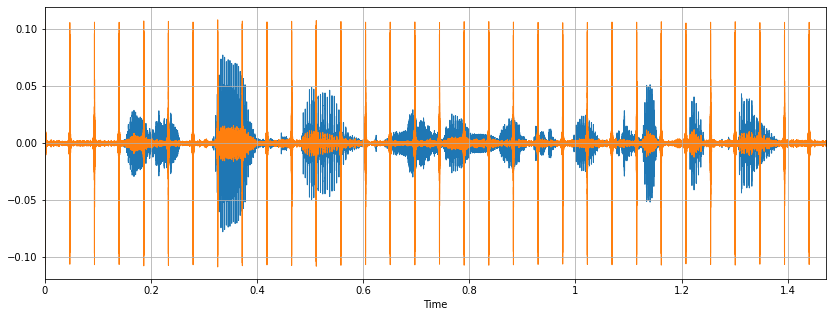

In [ ]:
idxs = [0]
for id in idxs:
    pred = model.infer(test_dataset[idx][0].to(device)).cpu().detach().numpy()
    true = test_dataset[idx][1].cpu().detach().numpy()
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(true)
    librosa.display.waveplot(pred)
    plt.grid()
    plt.show()

SNR -5 -получается не зашумленные аудио.
PESQ низкий, амплитуды на склейках получились большие, а сами аудио как-будто кто-то очень часто бьет молотком  - явная проблема со склейкой, при этом запись получилась похожая (возможно нужен меньше lr).

## Бонусная часть (5 баллов)

Одной из проблем текущей реализации предсказания на целой аудиозаписи являются краевые эфекты на границах сегментов. Чтобы избежать артефактов, берут сегменты с пересечением и усредняют результаты. 

- Реализуйте склейку сегментов с пересечением в пол размера сегмента. Для этого используйте [оконную функцию Ханна](https://en.wikipedia.org/wiki/Hann_function).

- Проанализируйте, как изменились результаты.

In [ ]:
# ¯\_(ツ)_/¯ your code here ¯\_(ツ)_/¯